# Simple Model

**Imports**

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import datasets

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

import mlflow
import mlflow.sklearn

plt.style.use('seaborn')

rcParams = plt.rcParams
font_size = 16
rcParams['font.size'] = font_size
rcParams['axes.labelsize'] = font_size
rcParams['xtick.labelsize'] = font_size
rcParams['ytick.labelsize'] = font_size
rcParams['legend.fontsize'] = font_size

**Load Dataset**

In [2]:
iris = datasets.load_iris()
iris.keys()

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename'])

In [3]:
data = pd.DataFrame(iris['data'],columns=iris['feature_names'])
data.columns = data.columns.str.replace(' ','_',regex=False).str.replace('_(cm)','',regex=False)
data['target'] = iris['target']
data['target_names'] = data['target'].replace(dict(zip(list(range(3)),iris['target_names'])))
data[:3]

,sepal_length,sepal_width,petal_length,petal_width,target,target_names
0,5.1,3.5,1.4,0.2,0,setosa
1,4.9,3.0,1.4,0.2,0,setosa
2,4.7,3.2,1.3,0.2,0,setosa


**Some EDA**

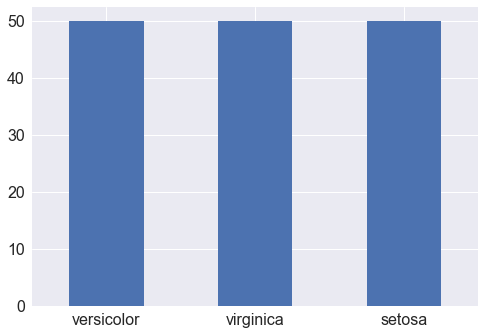

In [4]:
data['target_names'].value_counts().plot.bar(rot=0);

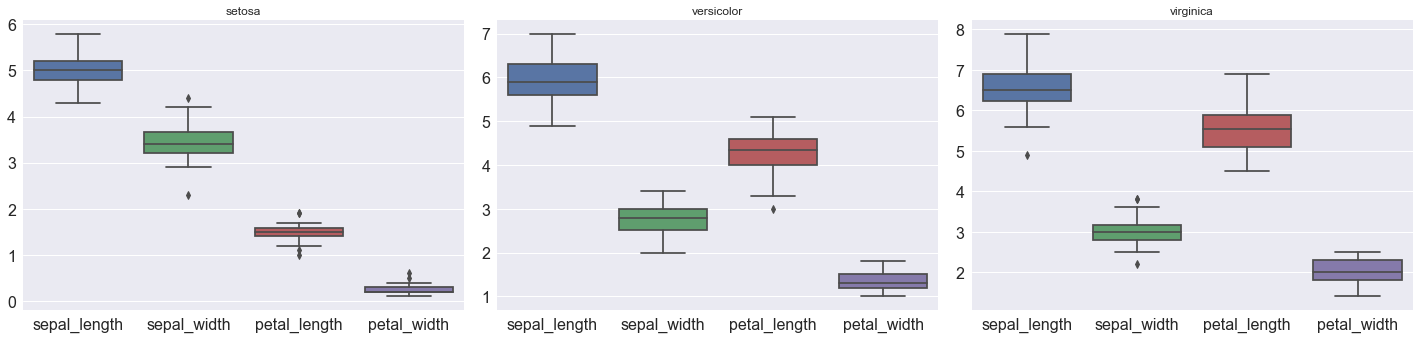

In [5]:
fig,ax = plt.subplots(1,3,figsize=(20,5))
for i,t in enumerate(data['target_names'].unique()):
    sns.boxplot(data=data.loc[data['target_names']==t].drop(['target','target_names'],axis=1),ax=ax[i]);
    ax[i].set_title(t)
plt.tight_layout()

Different Paramters for our model

In [6]:
Cs = [0.1,1.0,10,100,1000]
max_iter = [100,200,300,500,700,1000]

**Train/Test Split Data**

In [7]:
train, test = train_test_split(data.drop(['target_names'],axis=1),test_size=0.33,random_state=42,stratify=data['target'])

**Build and push Models**

Note: You need the credentials to be loaded in the environment for both client and server

In [8]:
from dotenv import find_dotenv, load_dotenv

In [18]:
load_dotenv(find_dotenv())

True

In [19]:
experiment_id = mlflow.create_experiment('Iris Classifier')
experiment = mlflow.get_experiment(experiment_id)

In [20]:
for C in tqdm(Cs):
    for mx in max_iter:
        # initiate run for current experiment
        mlflow.start_run(experiment_id=experiment_id)
        
        # model pipeline
        pipe = Pipeline(steps=[
                ('pre_processing', StandardScaler()),
                ('log_reg', LogisticRegression(C=C,max_iter=mx))
            ],
            verbose=False)
        
        # train model
        pipe.fit(train.drop(['target'],axis=1),train['target'])
        
        # predict 
        preds = pipe.predict(test.drop(['target'],axis=1))
        
        # log model parameters
        mlflow.log_param("C", C)
        mlflow.log_param("max_iter", mx)
        
        # get model scores
        acc = metrics.accuracy_score(test['target'],preds)
        prec = metrics.precision_score(test['target'],preds,average='weighted')
        
        # log scores
        mlflow.log_metric("acc", acc)
        mlflow.log_metric("precision", prec)
        
        # save model
        mlflow.sklearn.log_model(pipe, "model")
        
        # Display results
        fig = plt.figure(1)
        ax = plt.gca()
        
        sns.heatmap(metrics.confusion_matrix(test['target'],preds),annot=True,fmt='d',cmap='Blues',cbar=False)

        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title('Confusion Matrix',fontsize=16)
        plt.axis("tight")
        # Save figures
        fig.savefig("confusion-matrix.png")
        # Close plot
        plt.close(fig)
        # Log artifacts (output files)
        mlflow.log_artifact("confusion-matrix.png")
        # end run
        mlflow.end_run()

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:27<00:00,  5.44s/it]
